In [2]:
import os
import time
import shutil
import re
import string
import pickle as pkl
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import math
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Data Preprocessing

* Get Dataset Through Keras Package
* Data Preprocessing with nltk
* Covert Data to Pytorch Tensor

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file('aclImdb_v1', url, untar=True, cache_dir='', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb') # '/tmp/.keras/aclImdb'

84125825/84125825 [==============================] - 8s 0us/step


In [4]:
print(os.listdir(dataset_dir))
train_dir = os.path.join(dataset_dir, 'train')
print(f'Train Directory: {os.listdir(train_dir)}')
test_dir = os.path.join(dataset_dir, 'test')
print(f'Test Directory: {os.listdir(test_dir)}')

['imdb.vocab', 'README', 'test', 'train', 'imdbEr.txt']
Train Directory: ['neg', 'unsupBow.feat', 'unsup', 'labeledBow.feat', 'urls_unsup.txt', 'urls_neg.txt', 'urls_pos.txt', 'pos']
Test Directory: ['neg', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'pos']


In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/tmp/.keras/aclImdb/train',
    batch_size = batch_size,
    shuffle=False
)
# raw_valid_ds = tf.keras.utils.text_dataset_from_directory(
# '/tmp/.keras/aclImdb/train',
# batch_size = batch_size,
# validation_split = 0.2,
# subset='validation',
# seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/tmp/.keras/aclImdb/test',
    shuffle=False,
    batch_size = batch_size)

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
print(next(iter(raw_train_ds))[0][0]) # data
print()
print(next(iter(raw_train_ds))[1][0]) # label

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)

tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [ ]:
def get_text_label(raw_ds):
    list_text, list_label = [], []
    for data, _label in raw_ds:
        text = custom_standardization(data)
        revised_text = [t.numpy().decode('utf-8').replace('  ', ' ').strip() for t in text]
        label = _label.numpy().tolist()
        list_text.extend(revised_text)
        list_label.extend(label)
    return list_text, list_label

In [ ]:
raw_text, raw_label = get_text_label(raw_train_ds)
train_text, val_text, train_label, val_label = train_test_split(raw_text, raw_label, test_size=0.2, random_state=42)
test_text, test_label = get_text_label(raw_test_ds)

mean: 1261.72355
(700, 2474) (600, 1899) (800, 1882) (900, 1417) (1000, 1242) (1100, 976) (1200, 818) (500, 751) (1300, 723) (400, 704)


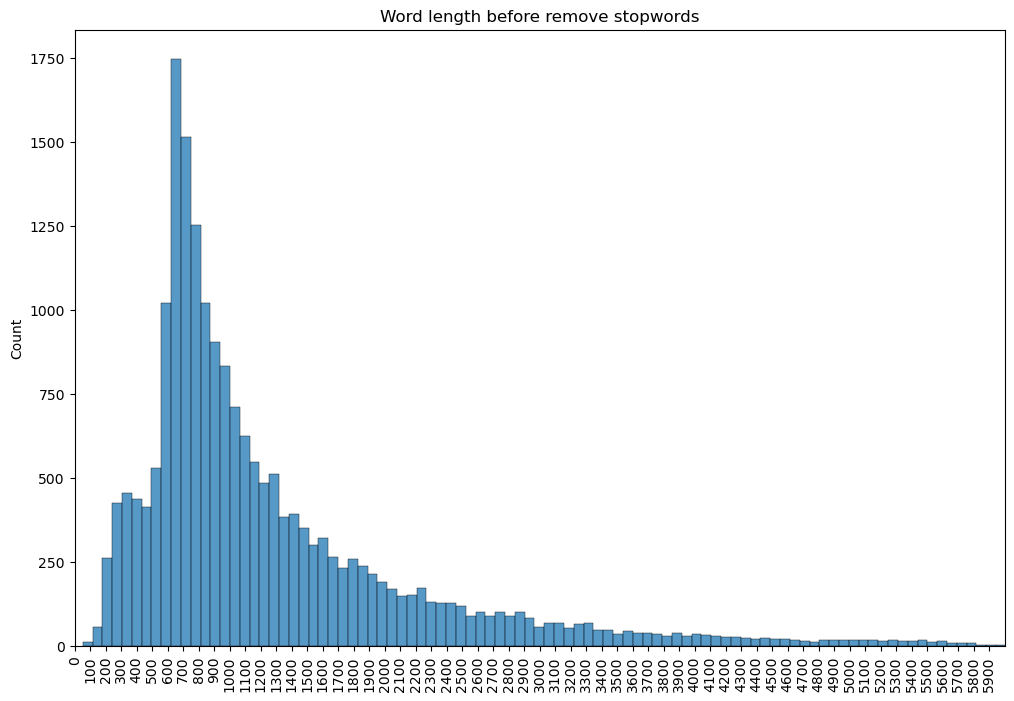

In [ ]:
length_count = np.array([len(train_t) for train_t in train_text])
upper_length_count = np.array([round(len(train_t), -2) for train_t in train_text])
plt.figure(figsize = (12, 8))
sns.histplot(length_count)
plt.xlim(0, 6000)
plt.xticks(np.arange(0, 6000, 100), rotation=90)
plt.title("Word length before remove stopwords")
print(f'mean: {length_count.mean()}')

# 700~800 사이가 제일 많다.
print(*sorted(Counter(upper_length_count).items(), key=lambda x: -x[1])[:10])


In [ ]:
def remove_stopwords(tokenizer, stopwords, texts):
    result = []
    for text in texts:
        sentence = []
        word_tokens = tokenizer(text)
        for token in word_tokens:
            if token not in stopwords:
                sentence.append(token)
        result.append(' '.join(sentence))
    return result

In [ ]:
word_tokenizer = word_tokenize
stopwords_list = stopwords.words('english')

train_without_stops = remove_stopwords(word_tokenizer, stopwords_list, train_text)
val_without_stops = remove_stopwords(word_tokenizer, stopwords_list, val_text)
test_without_stops = remove_stopwords(word_tokenizer, stopwords_list, test_text)

mean: 845.5924
mean: 621.0
(400, 3032) (500, 2994) (600, 2166) (700, 1571) (800, 1257) (300, 1099) (200, 1025) (900, 932) (1000, 836) (1100, 648)


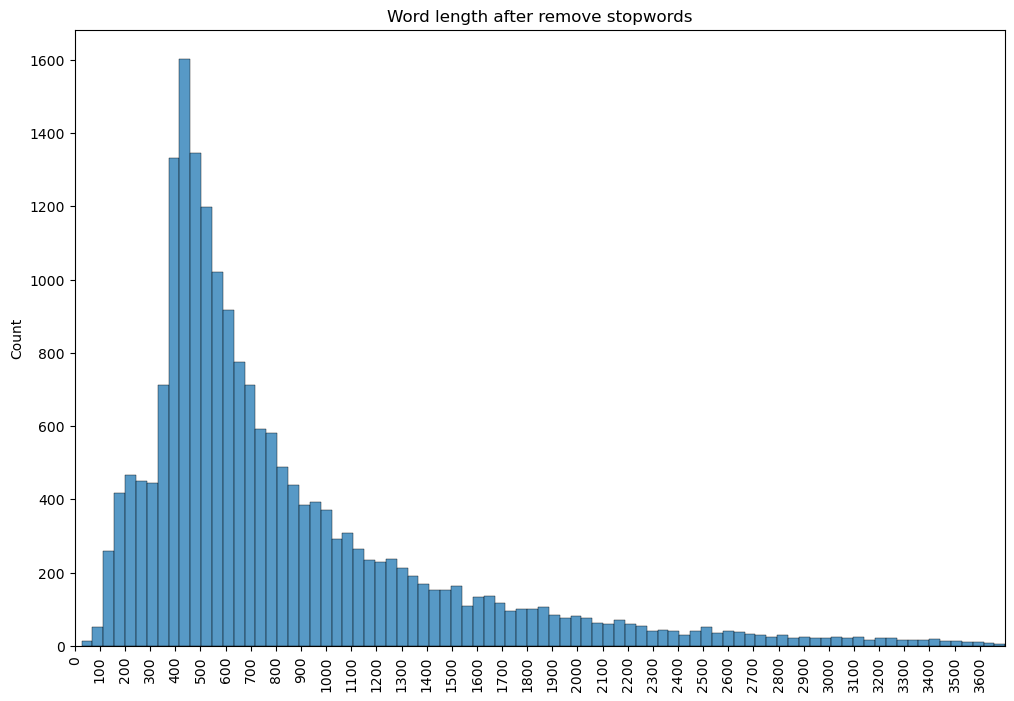

In [ ]:
ws_length_count = np.array([len(train_ws) for train_ws in train_without_stops])
ws_upper_length_count = np.array([round(len(train_ws), -2) for train_ws in train_without_stops])
plt.figure(figsize = (12, 8))
sns.histplot(ws_length_count)
plt.xlim(0, 3700)
plt.xticks(np.arange(0, 3700, 100), rotation=90)
plt.title("Word length after remove stopwords")
print(f'mean: {ws_length_count.mean()}')
print(f'mean: {np.median(ws_length_count)}')

# 400~500 사이가 제일 많다.
print(*sorted(Counter(ws_upper_length_count).items(), key=lambda x: -x[1])[:10])
